Log: Poprawnie wczytano dane. Liczba obserwacji: 1 345 350

--- STATYSTYKI ZMIENNEJ CELU (TARGET) ---
Klasa 0 (Kredyt spłacony):    1076751 (80.04%)
Klasa 1 (Kredyt niespłacony): 268599 (19.96%)


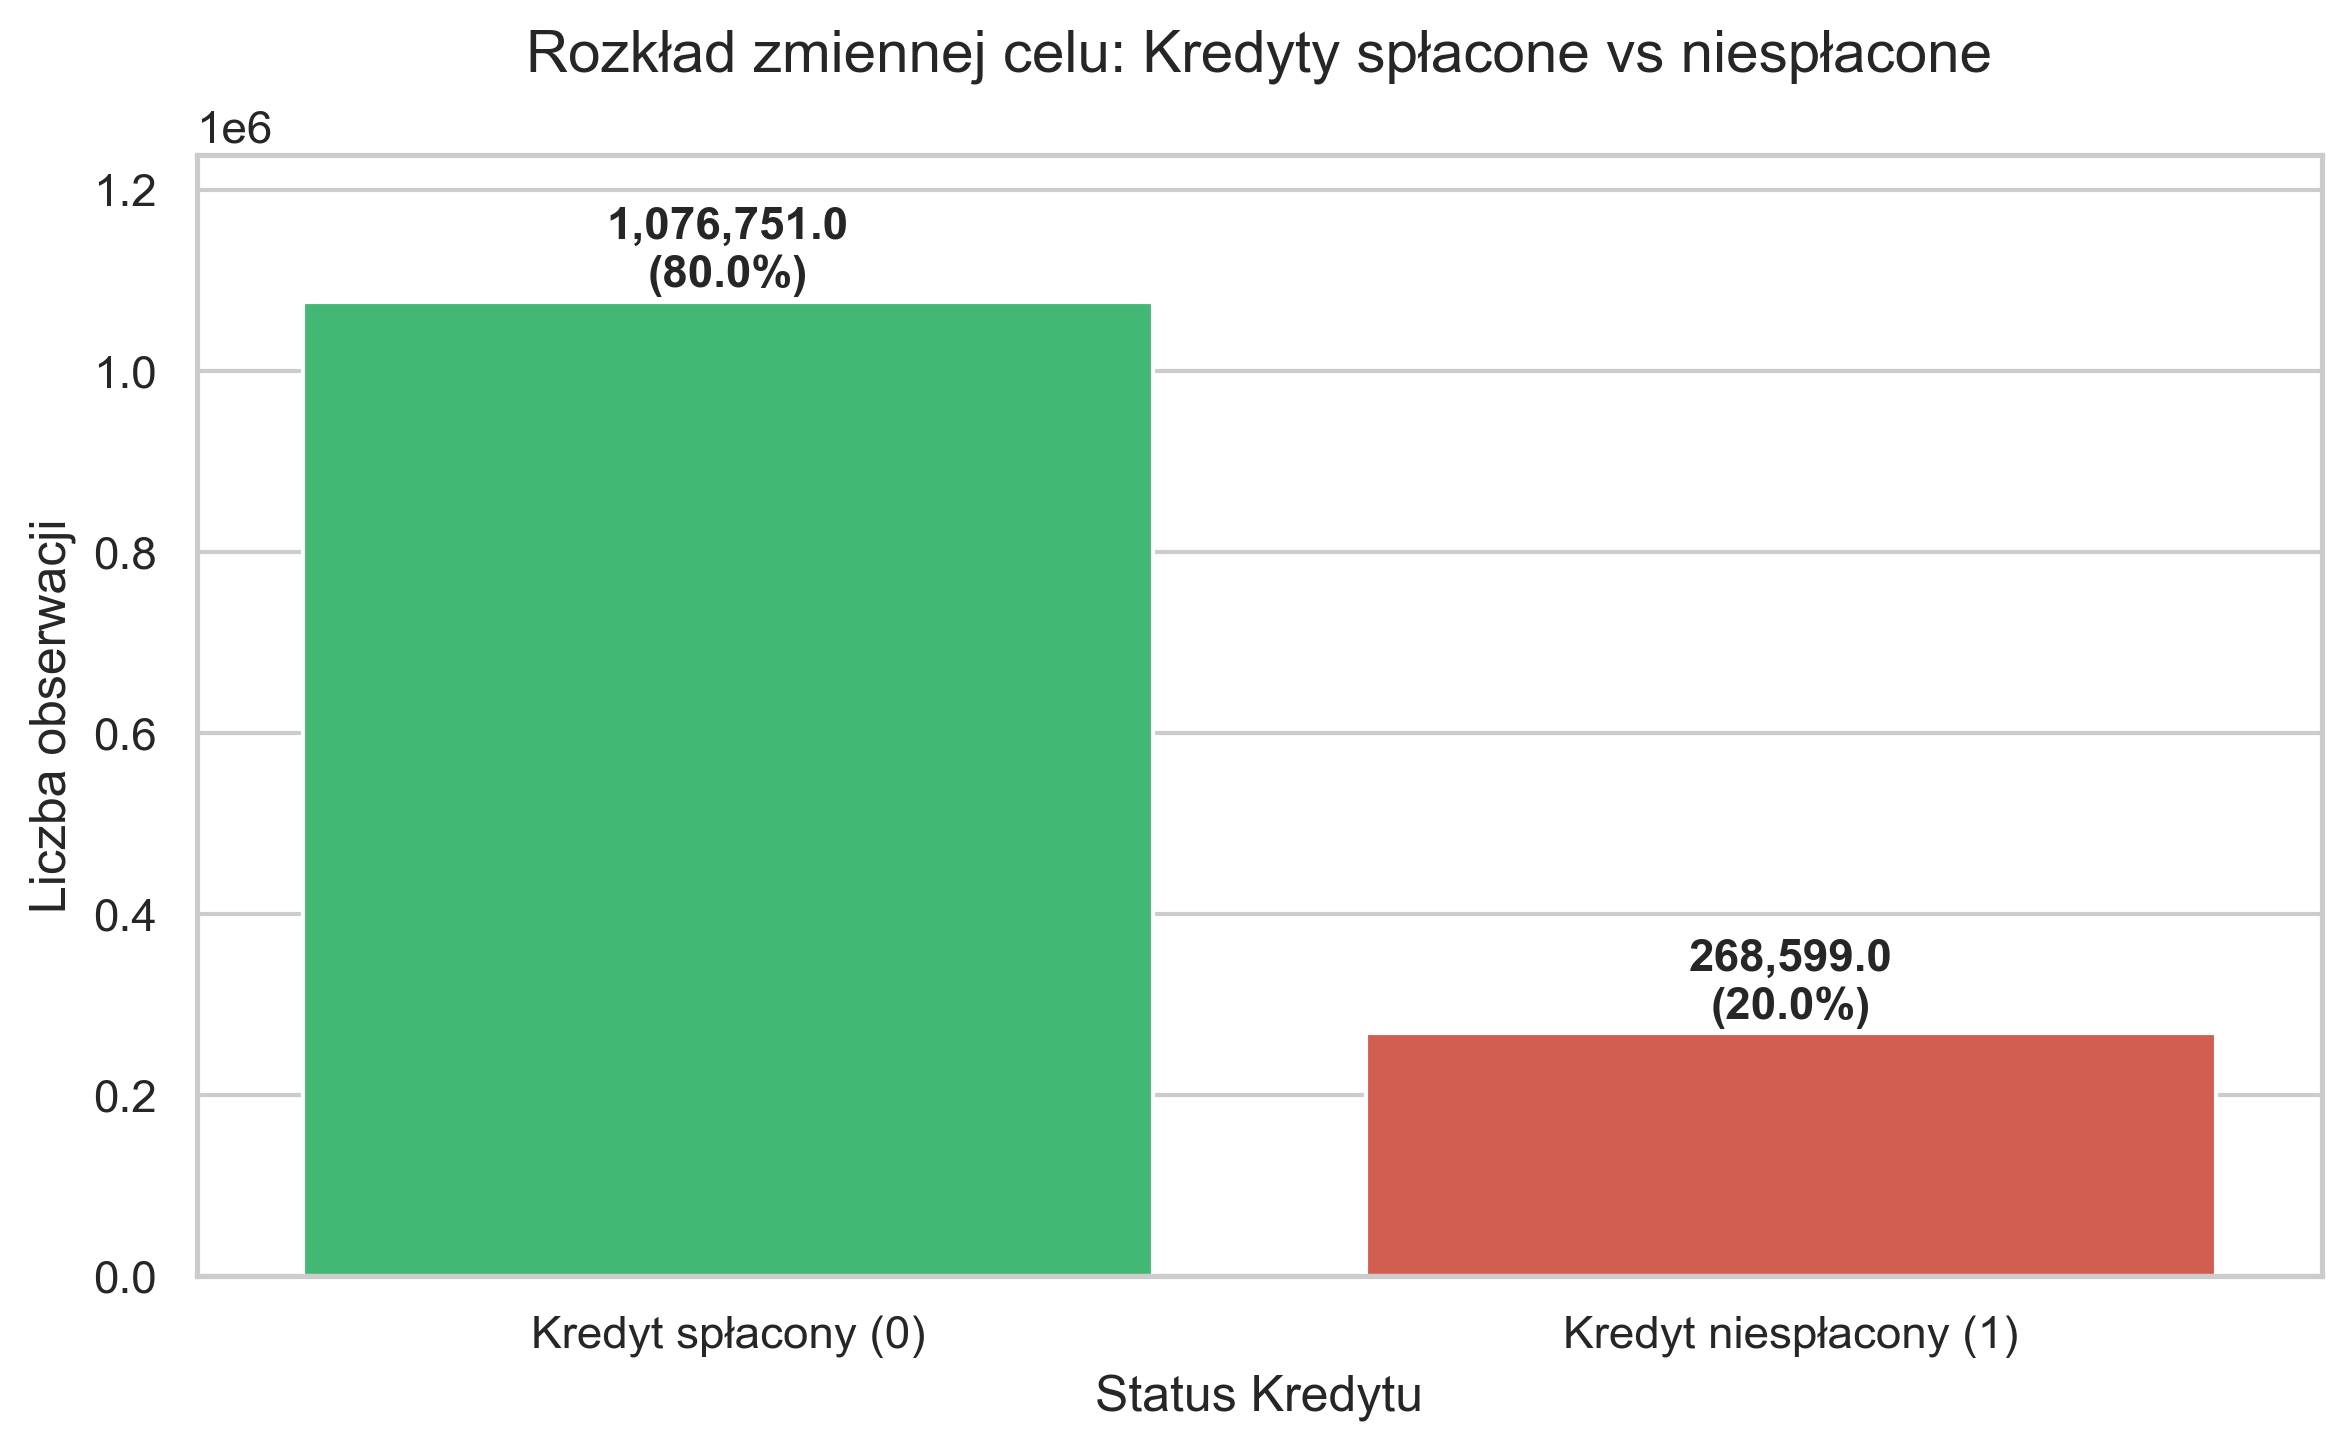

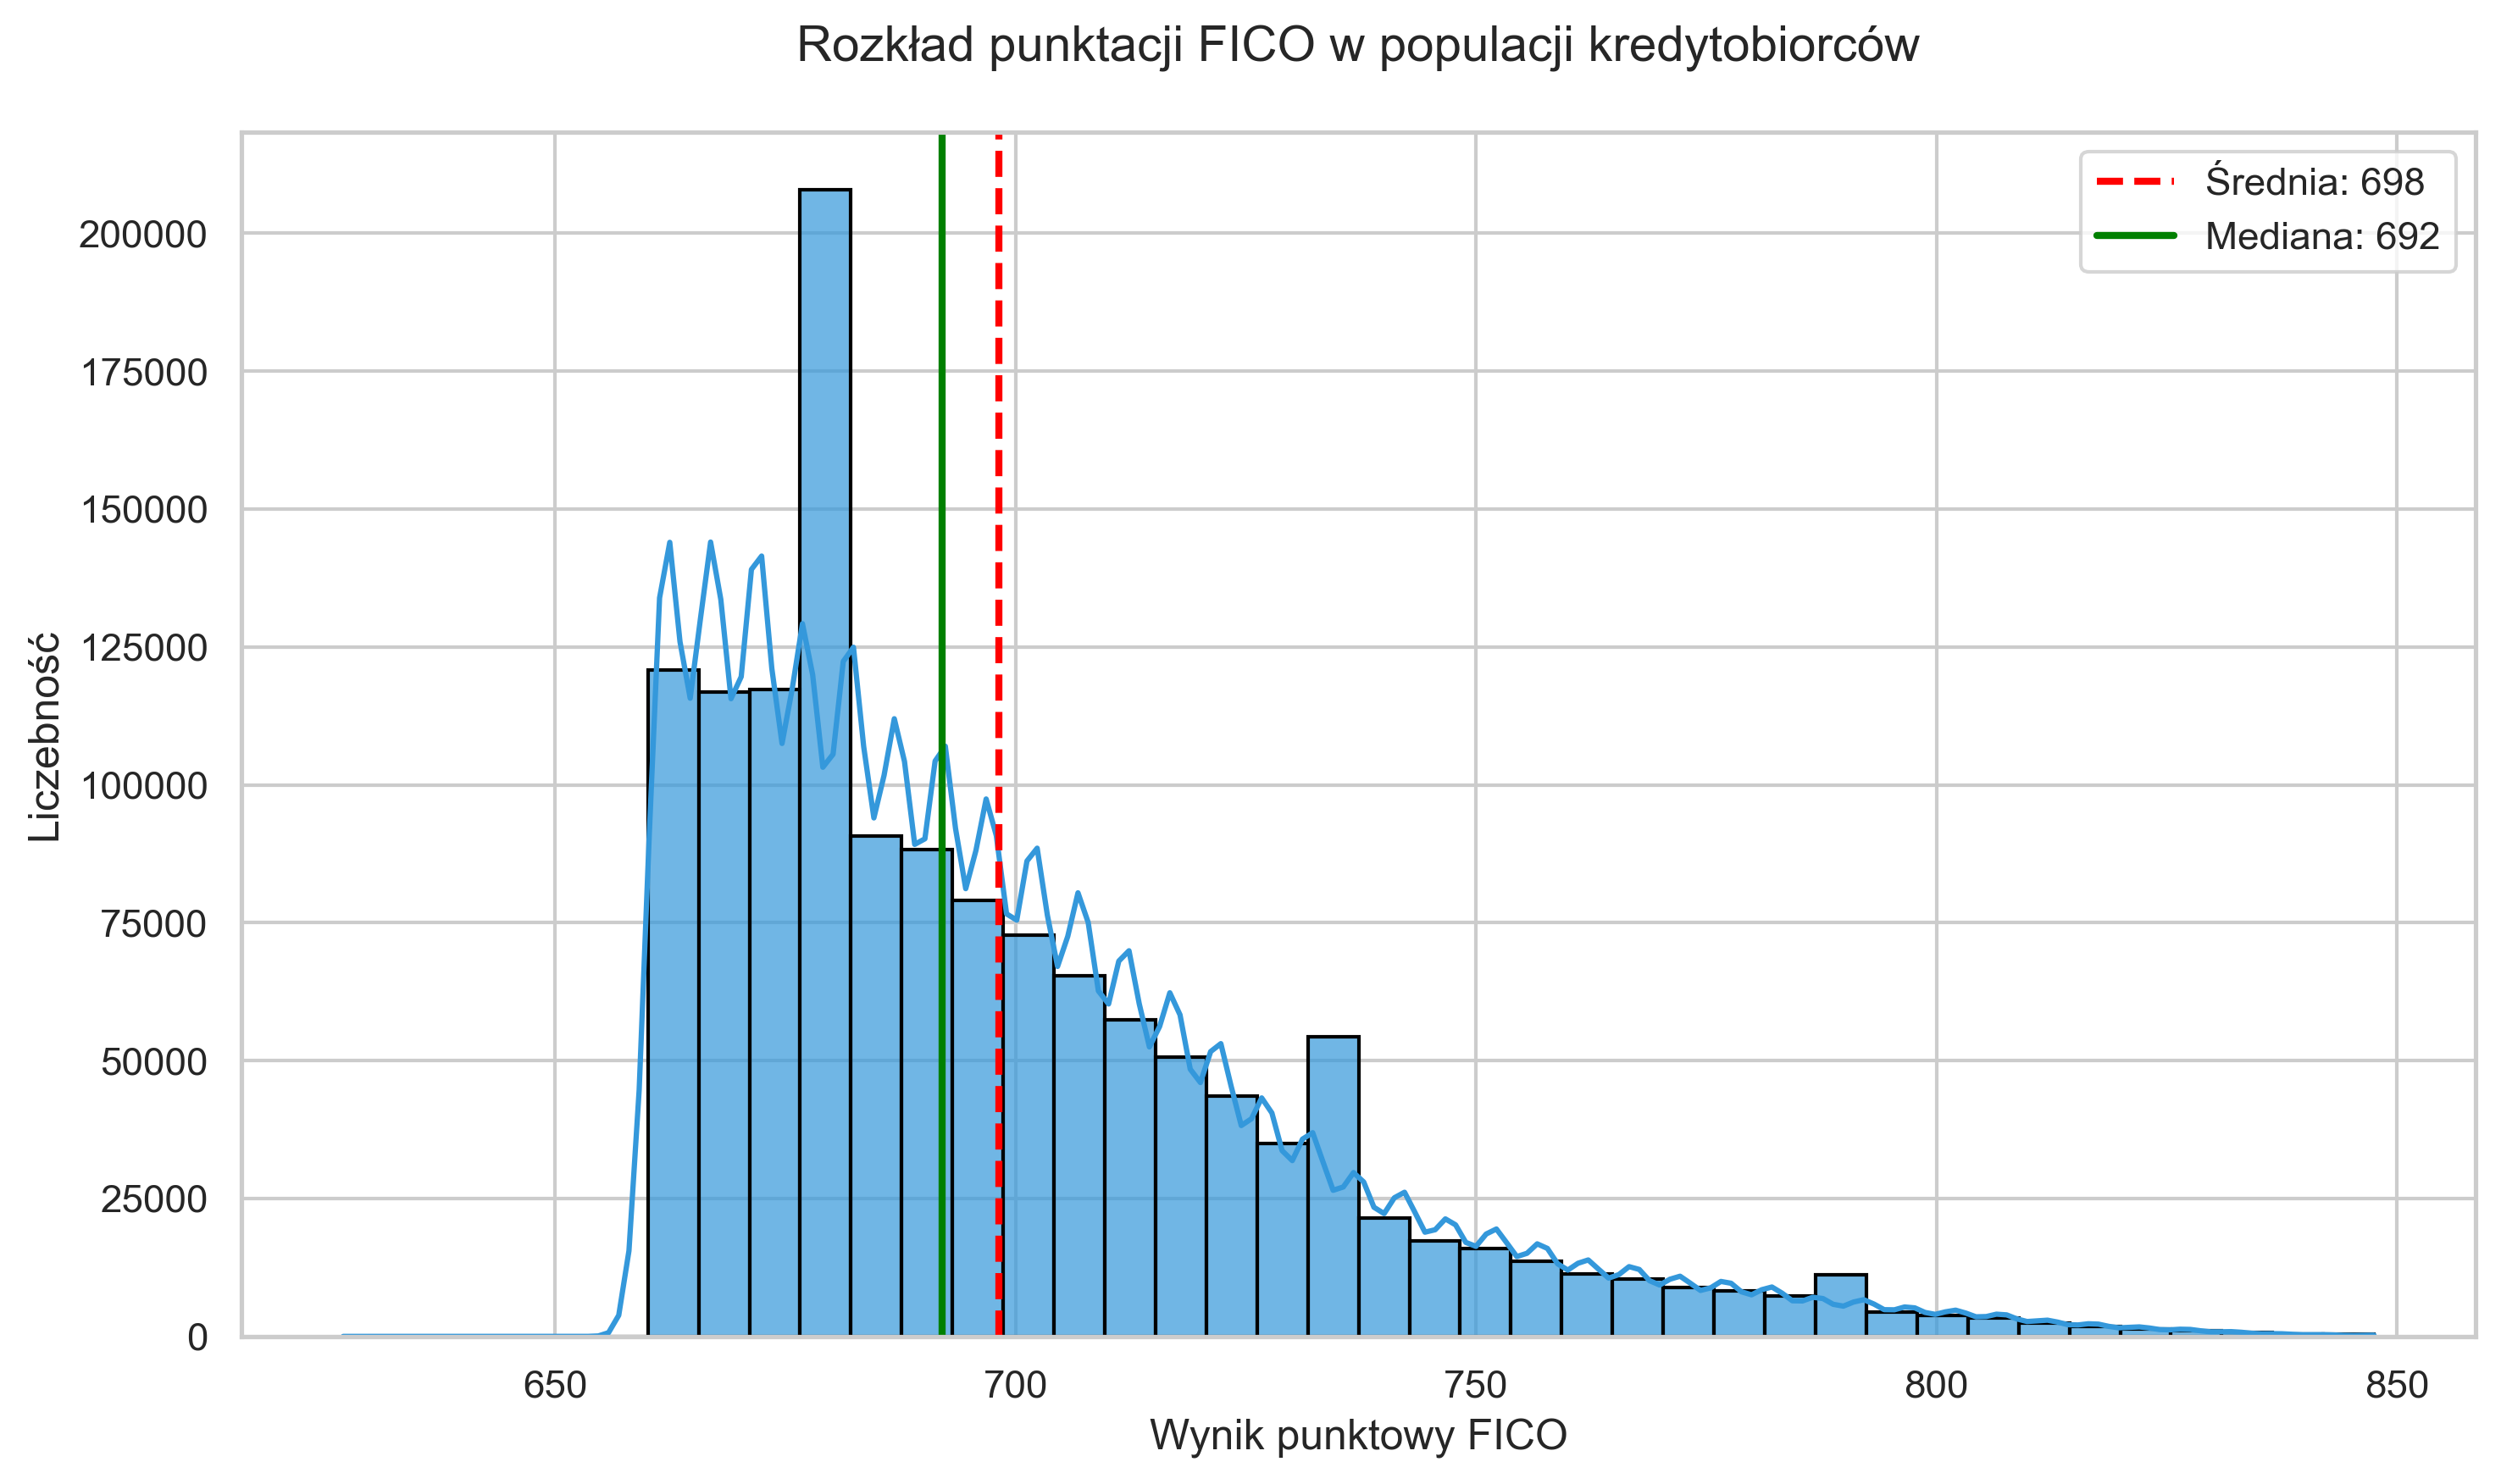


Log: Procedura zakończona pomyślnie. Wykresy zapisano w katalogu 'figures'.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- 1. KONFIGURACJA ŚRODOWISKA I PARAMETRÓW GRAFICZNYCH ---

# Ustawienie stylu wykresów (standard publikacyjny)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 300        # Rozdzielczość 300 DPI (standard druku)
plt.rcParams['savefig.dpi'] = 300       # Jakość zapisu plików wyjściowych
plt.rcParams['font.size'] = 12          # Bazowy rozmiar czcionki

# Weryfikacja istnienia katalogu wyjściowego na wykresy
if not os.path.exists('../figures'):
    os.makedirs('../figures')
    print("Log: Utworzono katalog 'figures' dla plików graficznych.")

# --- 2. IMPORT DANYCH ---

# Wczytanie przetworzonego zbioru danych (format CSV)
try:
    df = pd.read_csv('../data/lending_club_cleaned.csv')
    print(f"Log: Poprawnie wczytano dane. Liczba obserwacji: {df.shape[0]:,}".replace(',', ' '))
except FileNotFoundError:
    print("Błąd: Nie znaleziono pliku wejściowego w katalogu data.")

# --- 3. ANALIZA ROZKŁADU ZMIENNEJ CELU (TARGET) ---

# Obliczenie statystyk opisowych (liczebność i frakcja)
target_counts = df['target'].value_counts()
target_perc = df['target'].value_counts(normalize=True) * 100

print("\n--- STATYSTYKI ZMIENNEJ CELU (TARGET) ---")
print(f"Klasa 0 (Kredyt spłacony):    {target_counts[0]} ({target_perc[0]:.2f}%)")
print(f"Klasa 1 (Kredyt niespłacony): {target_counts[1]} ({target_perc[1]:.2f}%)")

# Inicjalizacja obiektu wykresu
fig, ax = plt.subplots(figsize=(8, 5))

# Generowanie wykresu słupkowego (POPRAWKA: dodano hue i legend=False)
bars = sns.barplot(
    x=target_counts.index, 
    y=target_counts.values, 
    hue=target_counts.index,  # Przypisanie kolorów do indeksu
    palette=['#2ecc71', '#e74c3c'], 
    legend=False,             # Ukrycie legendy (zbędna przy etykietach osi)
    ax=ax
)

# Implementacja etykiet danych (wartości liczbowe i procentowe na słupkach)
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    percentage = target_perc[i]
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 5000, 
        f'{height:,}\n({percentage:.1f}%)', 
        ha='center', va='bottom', fontsize=11, fontweight='bold'
    )

# Formatowanie osi i tytułu wykresu 
ax.set_title('Rozkład zmiennej celu: Kredyty spłacone vs niespłacone', fontsize=14, pad=20)
ax.set_xlabel('Status Kredytu', fontsize=12)
ax.set_ylabel('Liczba obserwacji', fontsize=12)

# Usztywnienie pozycji etykiet przed ich zmianą
ax.set_xticks([0, 1]) 
ax.set_xticklabels(['Kredyt spłacony (0)', 'Kredyt niespłacony (1)'])

ax.set_ylim(0, target_counts.max() * 1.15) # Korekta marginesu górnego

# Zapis wykresu do pliku w formacie PNG
plt.tight_layout()
plt.savefig('../figures/01_target_distribution.png')
plt.show()

# --- 4. ANALIZA ROZKŁADU PUNKTACJI FICO ---

# Wyznaczenie miar tendencji centralnej
mean_fico = df['fico_score'].mean()
median_fico = df['fico_score'].median()

# Inicjalizacja histogramu z estymatorem gęstości jądrowej (KDE)
plt.figure(figsize=(10, 6))
sns.histplot(df['fico_score'], bins=40, kde=True, color='#3498db', edgecolor='black', alpha=0.7)

# Naniesienie linii referencyjnych (średnia arytmetyczna i mediana)
plt.axvline(mean_fico, color='red', linestyle='--', linewidth=2, label=f'Średnia: {mean_fico:.0f}')
plt.axvline(median_fico, color='green', linestyle='-', linewidth=2, label=f'Mediana: {median_fico:.0f}')

# Formatowanie elementów wykresu
plt.title('Rozkład punktacji FICO w populacji kredytobiorców', fontsize=14, pad=20)
plt.xlabel('Wynik punktowy FICO', fontsize=12)
plt.ylabel('Liczebność', fontsize=12)
plt.legend()

# Zapis wykresu
plt.tight_layout()
plt.savefig('../figures/02_fico_distribution.png')
plt.show()

print("\nLog: Procedura zakończona pomyślnie. Wykresy zapisano w katalogu 'figures'.")

Analiza rozkładu punktacji FICO (Rysunek 2): Wykres prezentuje histogram punktacji FICO dla wszystkich zaakceptowanych wniosków kredytowych. Rozkład cechuje się wyraźną asymetrią prawostronną.

Kluczową obserwacją jest występowanie tzw. progu odcięcia (cut-off point) na poziomie około 660 punktów. Wskazuje to, że platforma Lending Club stosuje sztywną regułę decyzyjną ("Hard Rule"), automatycznie odrzucając wnioskodawców o niższej ocenie ryzyka, niezależnie od ich dochodów.

Średnia wartość FICO w badanej populacji wynosi 698 punktów, co pozycjonuje typowego klienta w segmencie podwyższonego ryzyka (Prime/Near-Prime). Niska reprezentacja klientów o bardzo wysokiej punktacji (>800) sugeruje, że osoby te korzystają z tańszych ofert tradycyjnego sektora bankowego, podczas gdy Lending Club zagospodarowuje niszę klientów o średniej wiarygodności.

Tradycyjne modele scoringowe biur kredytowych (takie jak FICO) koncentrują się na historii kredytowej (credit history), a nie na bieżącej zdolności finansowej (affordability). Zgodnie z oficjalną metodologią FICO, algorytm ten nie uwzględnia informacji o dochodach, statusie zatrudnienia ani majątku dłużnika.

Niniejsze badanie ma na celu wykazanie, że uzupełnienie oceny FICO o dane dochodowe (w szczególności wskaźnik DTI - Debt to Income) oraz dane behawioralne pozwala na istotną redukcję asymetrii informacji i lepszą predykcję niewypłacalności.


--- MACIERZ KORELACJI (Współczynniki r-Pearsona) ---


,fico_score,annual_inc,dti,loan_amnt
fico_score,1.0000,0.0710,-0.0619,0.1010
annual_inc,0.0710,1.0000,-0.1405,0.3118
dti,-0.0619,-0.1405,1.0000,0.0321
loan_amnt,0.1010,0.3118,0.0321,1.0000


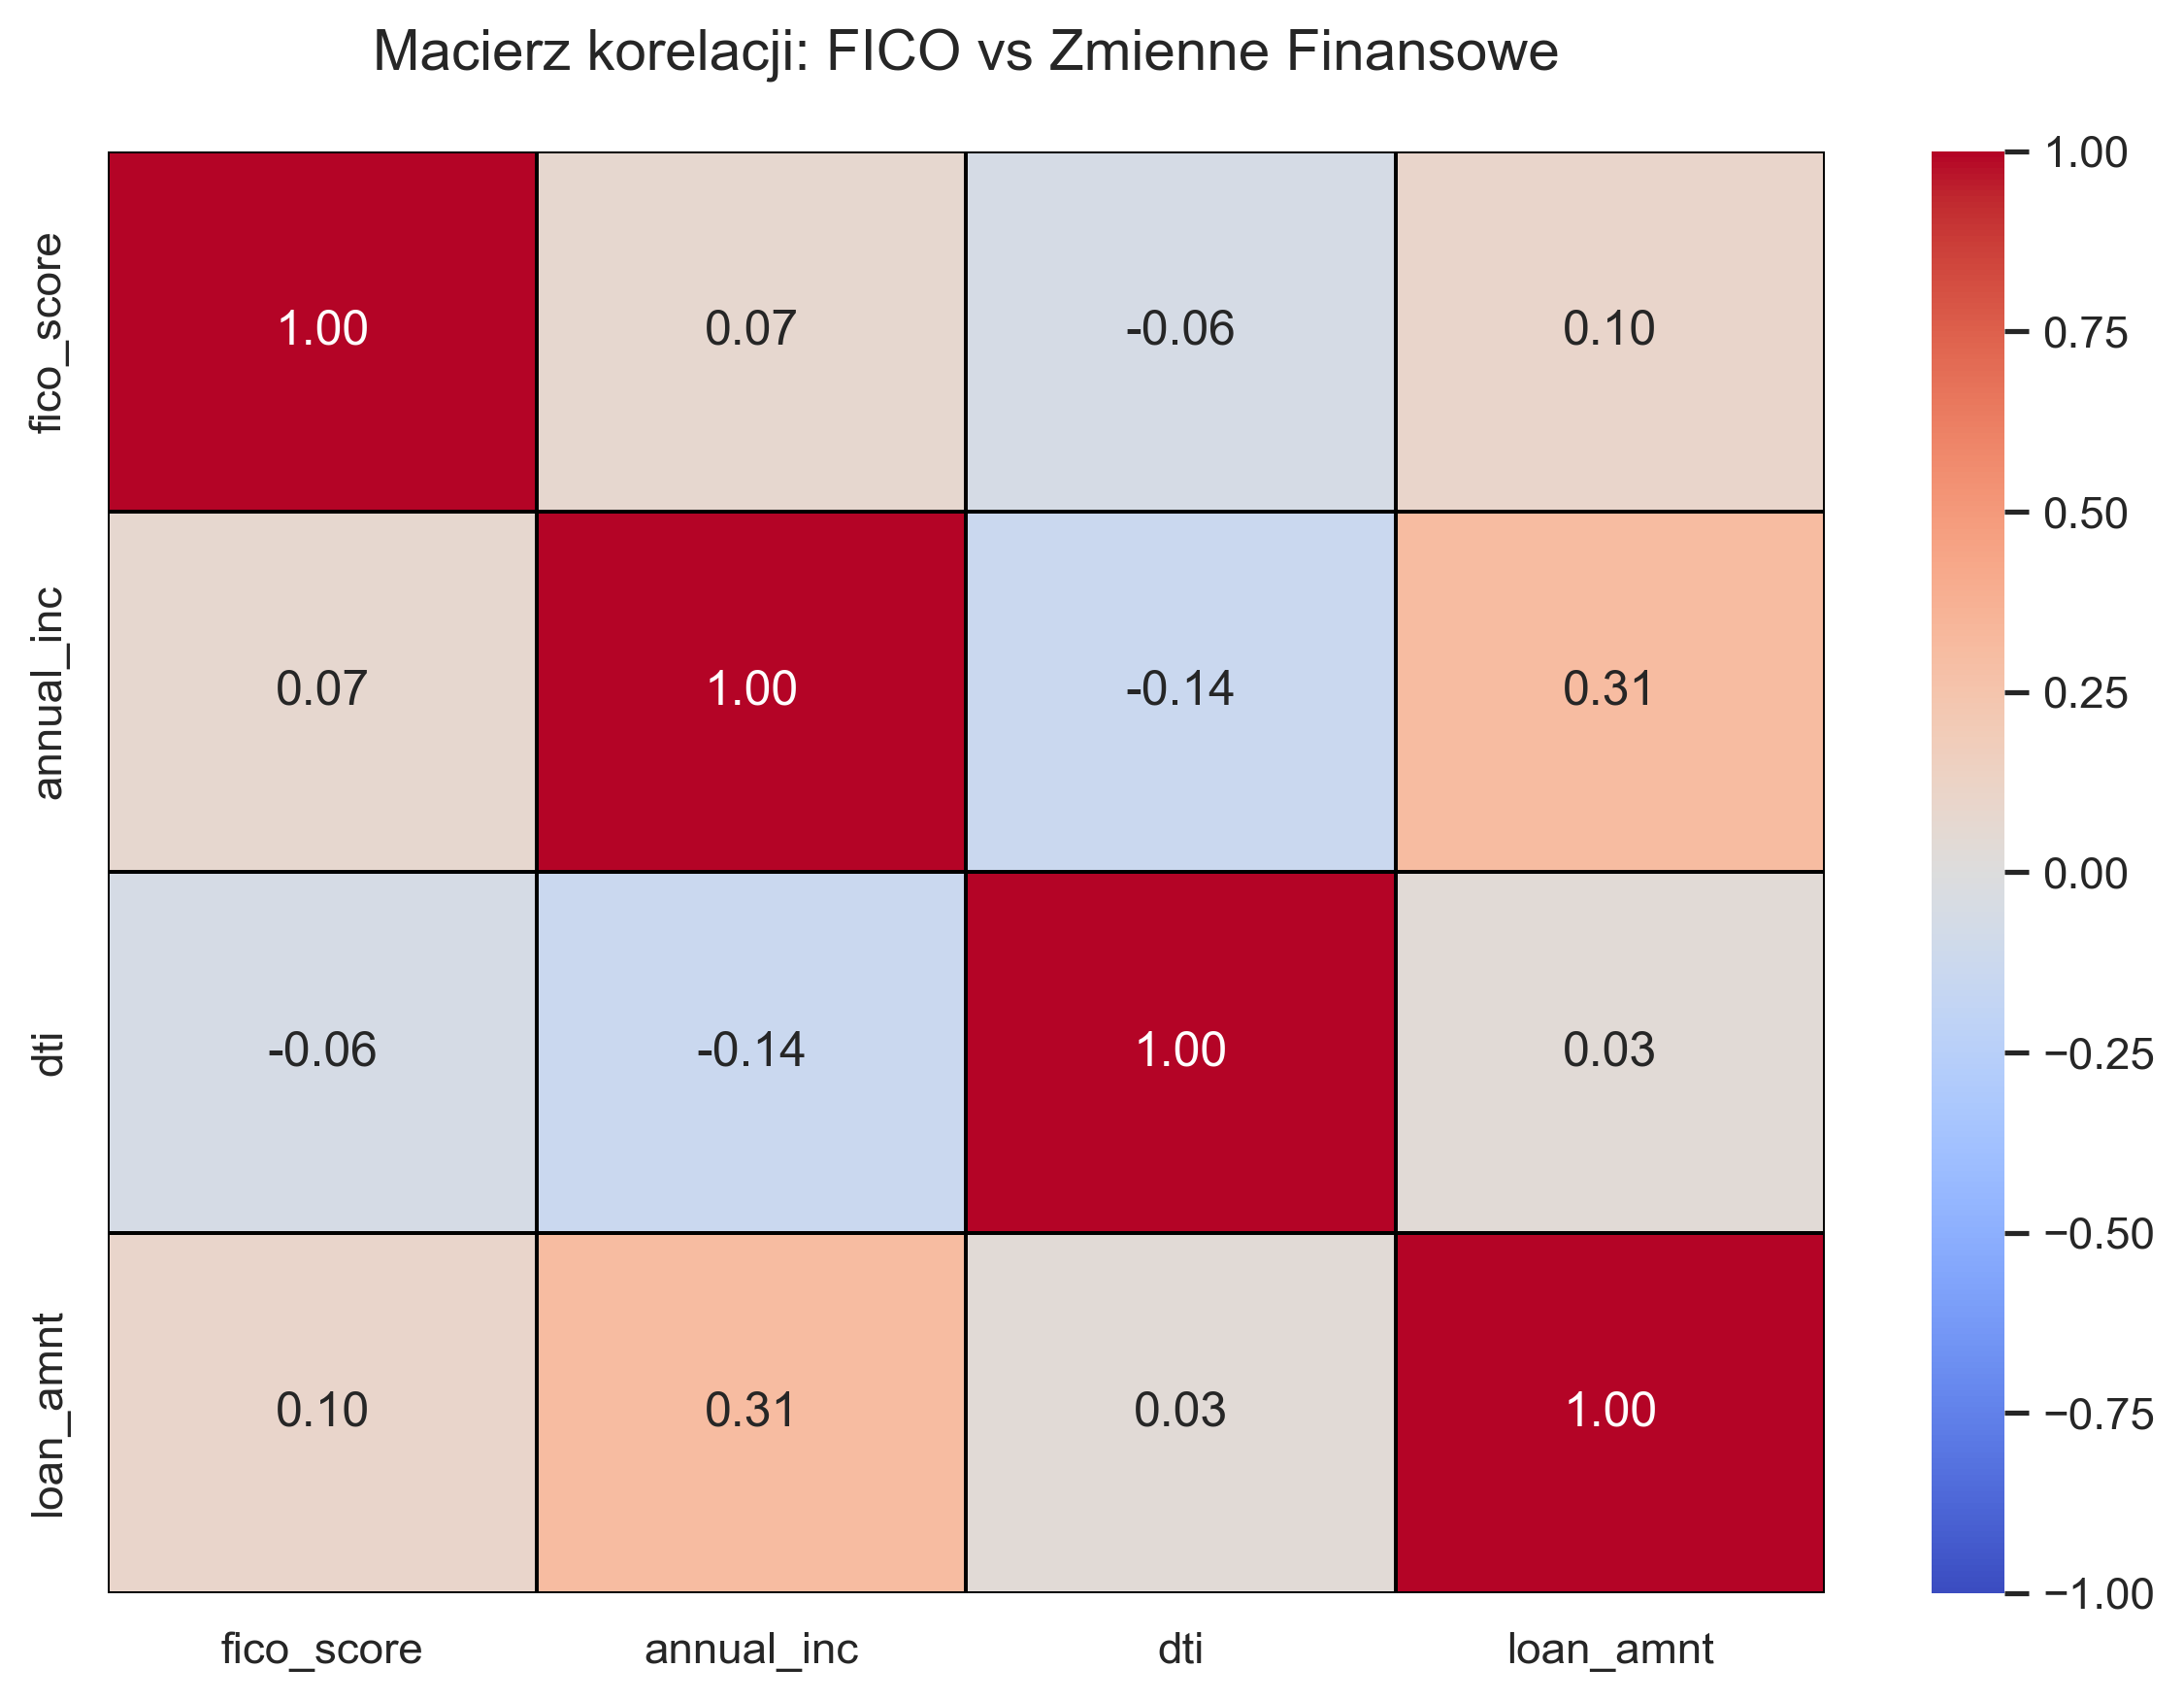

Log: Współczynnik korelacji r między FICO a Dochodem wynosi: 0.0710
WNIOSEK ANALITYCZNY: Stwierdzono brak istotnej korelacji liniowej.
   Wynik potwierdza, że ocena FICO jest niezależna od poziomu dochodów kredytobiorcy.


In [8]:
# --- 5. ANALIZA KORELACJI ZMIENNYCH (WERYFIKACJA NIEZALEŻNOŚCI FICO) ---

# Definicja zmiennych do analizy zależności
cols_to_check = ['fico_score', 'annual_inc', 'dti', 'loan_amnt']

# Obliczenie macierzy korelacji Pearsona
correlation_matrix = df[cols_to_check].corr()

print("\n--- MACIERZ KORELACJI (Współczynniki r-Pearsona) ---")
display(correlation_matrix.round(4))

# Wizualizacja macierzy korelacji (Heatmap)
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    vmin=-1, vmax=1, 
    linewidths=0.5, 
    linecolor='black'
)
plt.title('Macierz korelacji: FICO vs Zmienne Finansowe', fontsize=14, pad=20)

# Zapis wykresu
plt.tight_layout()
plt.savefig('../figures/03_correlation_matrix.png')
plt.show()

# Weryfikacja hipotezy o niezależności FICO od dochodu
fico_inc_corr = correlation_matrix.loc['fico_score', 'annual_inc']
print(f"Log: Współczynnik korelacji r między FICO a Dochodem wynosi: {fico_inc_corr:.4f}")

if abs(fico_inc_corr) < 0.2:
    print("WNIOSEK ANALITYCZNY: Stwierdzono brak istotnej korelacji liniowej.")
    print("   Wynik potwierdza, że ocena FICO jest niezależna od poziomu dochodów kredytobiorcy.")
else:
    print("UWAGA: Zaobserwowano umiarkowaną zależność między zmiennymi.")

Analiza macierzy korelacji wykazała, że współczynnik korelacji Pearsona pomiędzy punktacją FICO a rocznym dochodem kredytobiorcy wynosi zaledwie r = 0.07. Podobnie niska, ujemna korelacja występuje pomiędzy FICO a wskaźnikiem DTI (r = -0.06).

Wyniki te stanowią empiryczny dowód na to, że tradycyjna ocena wiarygodności kredytowej (FICO) jest zmienną niezależną od sytuacji dochodowej klienta. Potwierdza to zasadność budowy modelu, który integruje te dwa, rozłączne wymiary oceny ryzyka
